# Introduction to SQL
## March 29th, 2022
### Overview: An introductory foray into the SQL language

In [150]:
from matplotlib import pyplot as plt
import sqlite3 as sql
import numpy as np
import csv

In [37]:
# Problems 1, 2, and 4
def student_db(db_file="students.db", student_info="student_info.csv",
                                      student_grades="student_grades.csv"):
    """Connect to the database db_file (or create it if it doesn’t exist).
    Drop the tables MajorInfo, CourseInfo, StudentInfo, and StudentGrades from
    the database (if they exist). Recreate the following (empty) tables in the
    database with the specified columns.

        - MajorInfo: MajorID (integers) and MajorName (strings).
        - CourseInfo: CourseID (integers) and CourseName (strings).
        - StudentInfo: StudentID (integers), StudentName (strings), and
            MajorID (integers).
        - StudentGrades: StudentID (integers), CourseID (integers), and
            Grade (strings).

    Next, populate the new tables with the following data and the data in
    the specified 'student_info' 'student_grades' files.

                MajorInfo                         CourseInfo
            MajorID | MajorName               CourseID | CourseName
            -------------------               ---------------------
                1   | Math                        1    | Calculus
                2   | Science                     2    | English
                3   | Writing                     3    | Pottery
                4   | Art                         4    | History

    Finally, in the StudentInfo table, replace values of −1 in the MajorID
    column with NULL values.

    Parameters:
        db_file (str): The name of the database file.
        student_info (str): The name of a csv file containing data for the
            StudentInfo table.
        student_grades (str): The name of a csv file containing data for the
            StudentGrades table.
    """
    with sql.connect(db_file) as conn:
        cur = conn.cursor()
        #dropping tables and recreating them
        cur.execute('DROP TABLE IF EXISTS MajorInfo;')
        cur.execute('DROP TABLE IF EXISTS CourseInfo;')
        cur.execute('DROP TABLE IF EXISTS StudentInfo;')
        cur.execute('DROP TABLE IF EXISTS StudentGrades;')
        cur.execute('CREATE TABLE MajorInfo (MajorID INT, MajorName TEXT);')
        cur.execute('CREATE TABLE CourseInfo (CourseID INT, CourseName TEXT);')
        cur.execute('CREATE TABLE StudentInfo (StudentID INT, StudentName TEXT, MajorID INT);')
        cur.execute('CREATE TABLE StudentGrades (StudentID INT, CourseID INT, Grade TEXT);')
        
        #creating data for MajorInfo and CourseInfo
        majorinfo = [[1,"Math"],[2,"Science"],[3,"Writing"],[4,"Art"]]
        courseinfo = [[1, "Calculus"],[2,"English"],[3,"Pottery"],[4,"History"]]
        
        #populating tables
        cur.executemany("INSERT INTO MajorInfo VALUES(?,?);",majorinfo)
        cur.executemany("INSERT INTO CourseInfo VALUES(?,?);",courseinfo)
        
        with open(student_info, 'r') as infile:
            info_rows = list(csv.reader(infile))
            cur.executemany("INSERT INTO StudentInfo VALUES(?,?,?);",info_rows)
            
        with open(student_grades, 'r') as infile:
            grade_rows = list(csv.reader(infile))
            cur.executemany("INSERT INTO StudentGrades VALUES(?,?,?);",grade_rows)
        
        #updating all values of -1 to be NULL
        cur.execute("UPDATE StudentInfo SET MajorID=NULL WHERE MajorID==-1;")
        
        conn.commit()
    
    conn.close()

In [72]:
# Problems 3 and 4
def earthquakes_db(db_file="earthquakes.db", data_file="us_earthquakes.csv"):
    """Connect to the database db_file (or create it if it doesn’t exist).
    Drop the USEarthquakes table if it already exists, then create a new
    USEarthquakes table with schema
    (Year, Month, Day, Hour, Minute, Second, Latitude, Longitude, Magnitude).
    Populate the table with the data from 'data_file'.

    For the Minute, Hour, Second, and Day columns in the USEarthquakes table,
    change all zero values to NULL. These are values where the data originally
    was not provided.

    Parameters:
        db_file (str): The name of the database file.
        data_file (str): The name of a csv file containing data for the
            USEarthquakes table.
    """
    with sql.connect(db_file) as conn:
        cur = conn.cursor()
        cur.execute("DROP TABLE IF EXISTS USEarthquakes")
        cur.execute("CREATE TABLE USEarthquakes (Year INT, Month INT, Day INT, Hour INT, Minute INT,"
                    " Second INT, Latitude REAL, Longitude REAL, Magnitude REAL);")
        
        with open(data_file,'r') as infile:
            data = list(csv.reader(infile))
            cur.executemany("INSERT INTO USEarthquakes VALUES(?,?,?,?,?,?,?,?,?);",data)
        
        #removing rows with earthquakes of 0 magnitude
        cur.execute("DELETE FROM USEarthquakes WHERE Magnitude==0;")
        #replacing the time variables with NULL where they are 0
        cur.execute("UPDATE USEarthquakes SET Day=NULL WHERE Day==0;")
        cur.execute("UPDATE USEarthquakes SET Hour=NULL WHERE Hour==0;")
        cur.execute("UPDATE USEarthquakes SET Minute=NULL WHERE Minute==0;")
        cur.execute("UPDATE USEarthquakes SET Second=NULL WHERE Second==0;")
        
        conn.commit()
    conn.close()

In [74]:
earthquakes_db()

In [123]:
# Problem 5
def prob5(db_file="students.db"):
    """Query the database for all tuples of the form (StudentName, CourseName)
    where that student has an 'A' or 'A+'' grade in that course. Return the
    list of tuples.

    Parameters:
        db_file (str): the name of the database to connect to.

    Returns:
        (list): the complete result set for the query.
    """
    with sql.connect(db_file) as conn:
        cur = conn.cursor()
        
        #getting the student and course names where the grade is an A+ or A
        cur.execute("SELECT SI.StudentName, CI.CourseName FROM StudentInfo AS SI, CourseInfo AS CI, StudentGrades AS SG"
                    " WHERE SI.StudentID=SG.StudentID AND CI.CourseID=SG.CourseID AND (SG.Grade='A+' OR SG.Grade='A');")
        As = cur.fetchall()
        
    conn.close()
    return As

In [190]:
# Problem 6
def prob6(db_file="earthquakes.db"):
    """Create a single figure with two subplots: a histogram of the magnitudes
    of the earthquakes from 1800-1900, and a histogram of the magnitudes of the
    earthquakes from 1900-2000. Also calculate and return the average magnitude
    of all of the earthquakes in the database.

    Parameters:
        db_file (str): the name of the database to connect to.

    Returns:
        (float): The average magnitude of all earthquakes in the database.
    """
    with sql.connect(db_file) as conn:
        cur = conn.cursor()
        
        #getting, as lists, earthquakes in the 19th and 20th centuries
        cur.execute("SELECT Magnitude FROM USEarthquakes WHERE (Year > 1799 AND Year < 1900);")
        mags19th = [mag[0] for mag in cur.fetchall()]
        cur.execute("SELECT Magnitude FROM USEarthquakes WHERE (Year > 1899 AND Year < 2000);")
        mags20th = [mag[0] for mag in cur.fetchall()]
        
        #getting the average magnitude of all earthquakes in the database 
        cur.execute("SELECT AVG(Magnitude) FROM USEarthquakes")
        avgMag = cur.fetchall()[0][0]
    conn.close()
    
    #plotting
    fig, axs = plt.subplots(nrows=1,ncols=2)
    fig.set_size_inches(14,6)
    
    #19th century
    axs[0].hist(mags19th, bins=np.arange(3,8.5,0.5), ec='k',color='g')
    axs[0].set_title("19th Century Earthquake Magnitudes")
    axs[0].set_xlabel("Magnitude")
    axs[0].set_ylabel("Number of Occurrences")
    
    #20th century
    axs[1].hist(mags20th, bins=np.arange(2.5,9,0.5),ec='k',color='crimson')
    axs[1].set_title("20th Century Earthquake Magnitudes")
    axs[1].set_xlabel("Magnitude")
    
    return avgMag

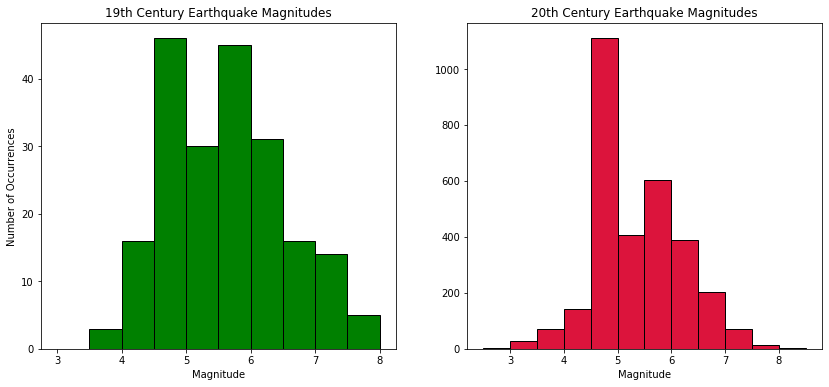

In [191]:
m = prob6()